In [1]:
from __future__ import print_function, division, unicode_literals

import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple of utility functions to plot grayscale 28x28 images

In [2]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min() # make the minimum == 0, so the padding looks white
    w, h = images.shape[1:]
    image = np.zeros(((w+pad) * n_rows + pad,
                     (h+pad) * n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),
                  (x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

Autoencoders can do many things:
* they learn efficient representations of the input, known as coding, without any supervision
* codings can have dimensionality less than the input, thus they achieve Dimensionality Reduction
* they can act as powerful feature detectors
* they are capable of randomly generating new data that is very similar to the training data, thus they can act as a generative model

Task performed by Autoencoder is not trivial:
* can limit the size of internal representation
* can add noise to the input and train the network to recover the original inputs

Constraints prevent the autoencoder to copy the input to the outpus.

Dimensionality of input and output is the same.

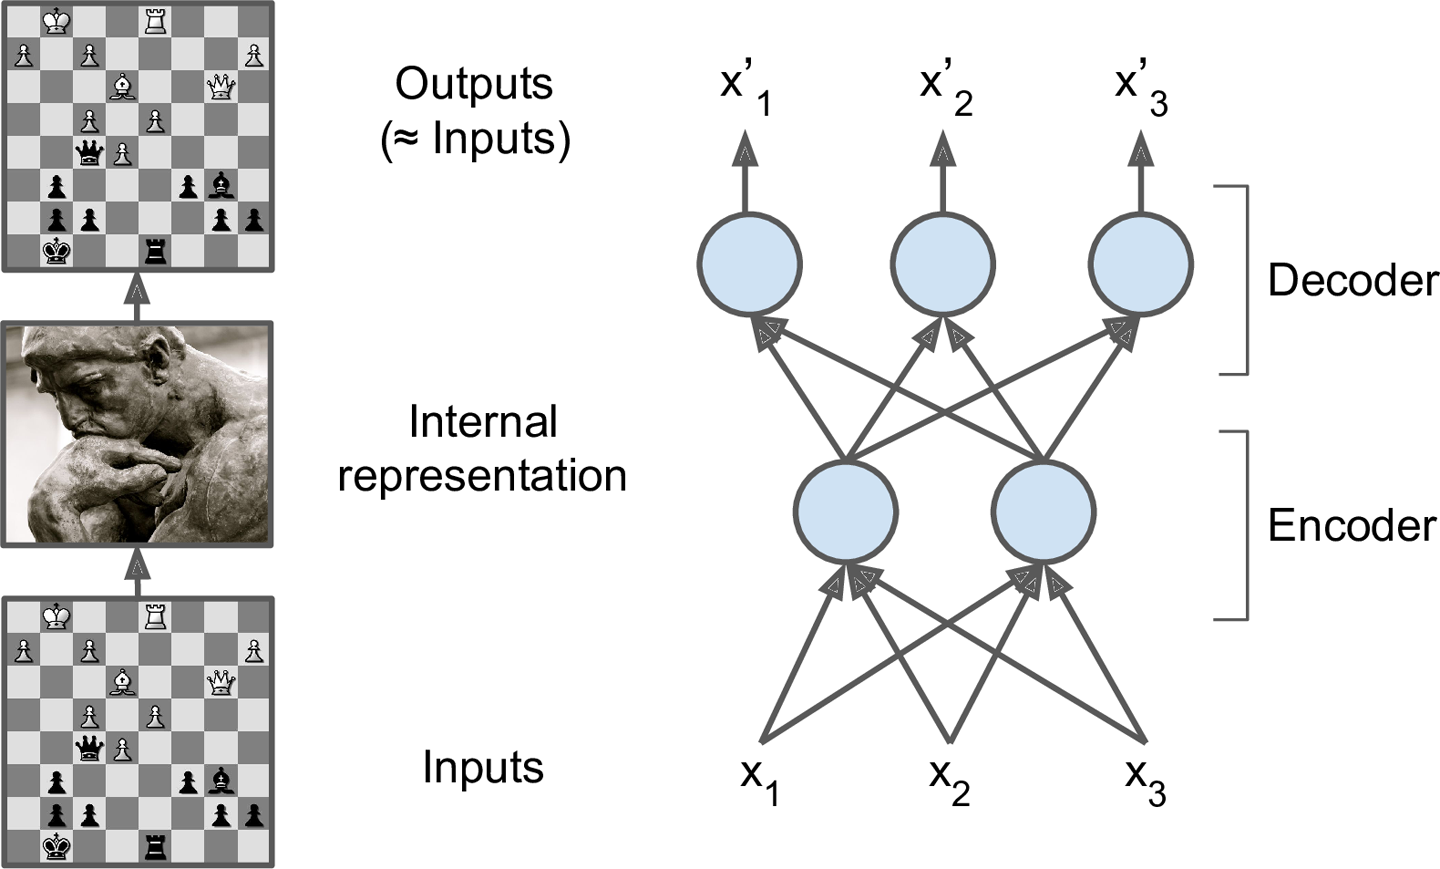

## PCA with a linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the Mean Squared Error (MSE), then it can be shown that it ends up performing Principal Component Analysis

Buil 3D dataset:

In [3]:
import numpy.random as rnd
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Preprocess data

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[:100])

In [6]:
import tensorflow as tf

In [7]:
reset_graph()

n_inputs = 3
n_hidden = 2 # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [9]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


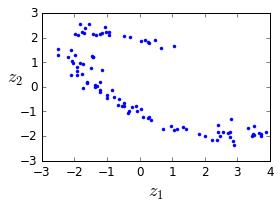

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders

Provide layers to autoencoder hidden layer to learn more complex representations of the input data.

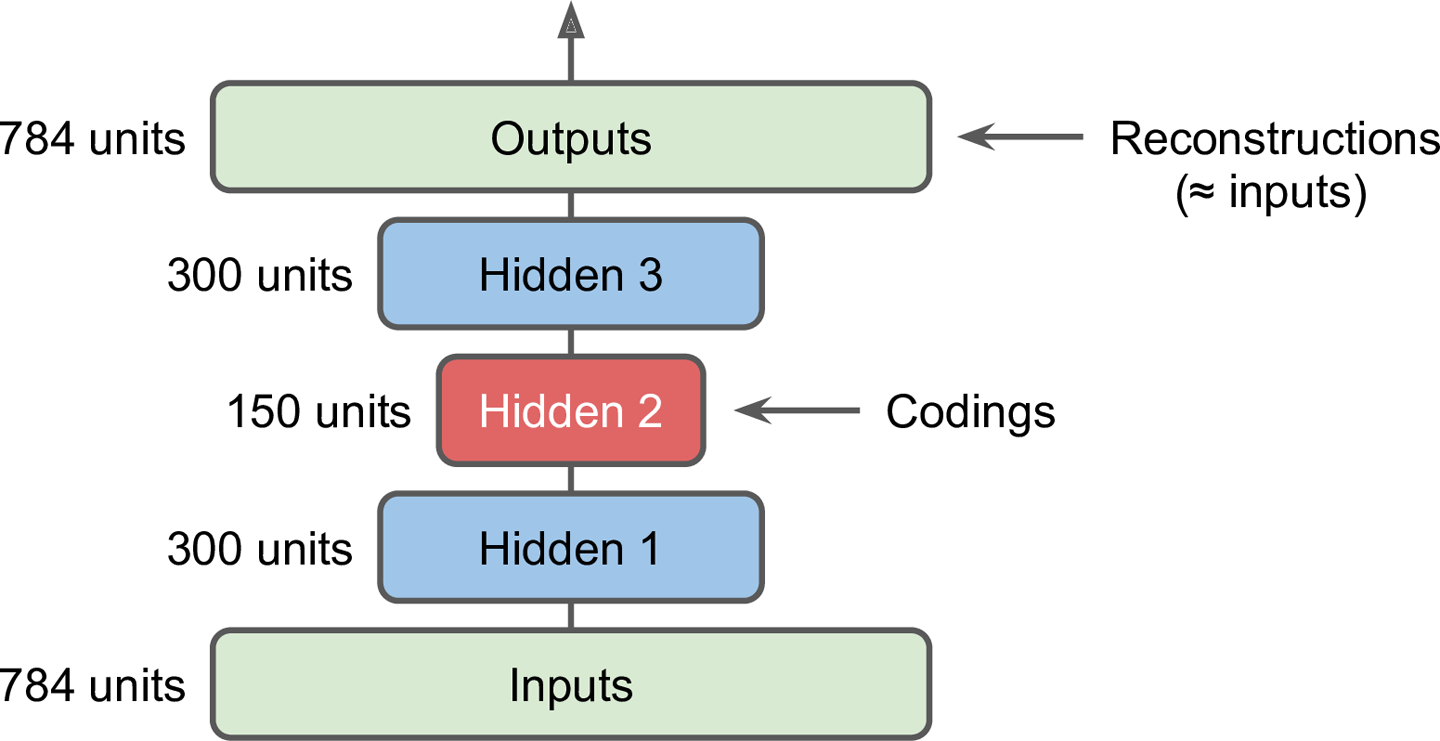

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./datasets/mnist1/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./datasets/mnist1/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./datasets/mnist1/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./datasets/mnist1/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./datasets/mnist1/t10k-labels-idx1-ubyte.gz


Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`).

In [12]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's train! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [13]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

09% Train MSE: 0.023305
19% Train MSE: 0.0115295
29% Train MSE: 0.0104114
39% Train MSE: 0.0101625
49% Train MSE: 0.00977806


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [14]:
def show_reconstructed_digits(X, outputs, model_path = None,
                             n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        
        fig = plt.figure(figsize=(8, 3 * n_test_digits))
        for digit_index in range(n_test_digits):
            plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
            plot_image(X_test[digit_index])
            plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
            plot_image(outputs_val[digit_index])

Saving figure reconstruction_plot


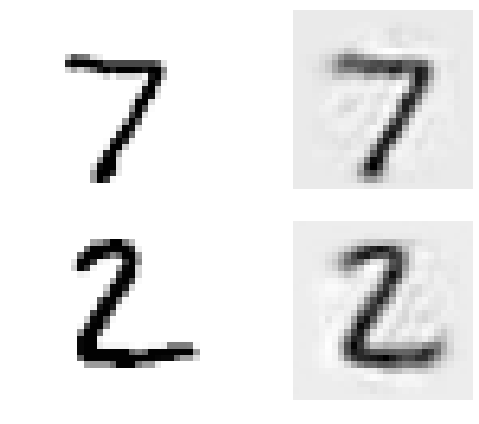

In [15]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## Tying Weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers `(weights_decoder = tf.transpose(weights_encoder))`. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting.
Specifically, if the autoencoder has a total of $N$ layers (not counting the input layer), and $W_{l}$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer  is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_{L}^{T}$ (with  L = 1, 2,$\ldots , \frac{N}{2}$).Unfortunately, implementing tied weights in TensorFlow using the `fully_connected()` function is a bit cumbersome; it’s actually easier to just define the layers manually.


In [16]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

wt1_init = initializer([n_inputs, n_hidden1])
wt2_init = initializer([n_hidden1, n_hidden2])

# wt3 and wt4 are NOT variables but transpose of wt2 and wt1 respectively
# thus they are tied
# wt3 and wt4 are NOT regularized (since they are not varaibles)
# biases are never tied nor regularized

wt1 = tf.Variable(wt1_init, dtype=tf.float32, name="weights1")
wt2 = tf.Variable(wt2_init, dtype=tf.float32, name="weights2")
wt3 = tf.transpose(wt2, name="weights3") # tied weights
wt4 = tf.transpose(wt1, name="weights4") # tied weights

b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, wt1) + b1)
hidden2 = activation(tf.matmul(hidden1, wt2) + b2)
hidden3 = activation(tf.matmul(hidden2, wt3) + b3)
outputs = activation(tf.matmul(hidden3, wt4) + b4)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(wt1) + regularizer(wt2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0165294
19% Train MSE: 0.0165421
29% Train MSE: 0.0165554
39% Train MSE: 0.0163054
4 Train MSE: 0.0169105


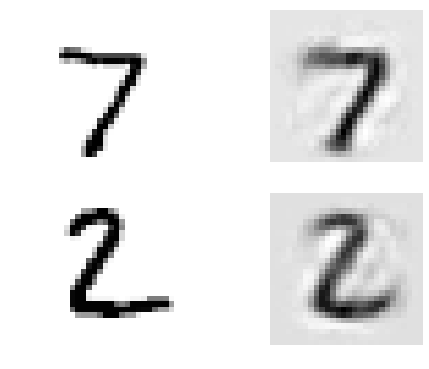

In [22]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## Training one Autoencoder at a time in <br/>multiple graphs

Its often more faster to train multiple shallow autoencoders and then stack them together to form a deep autoencoder.

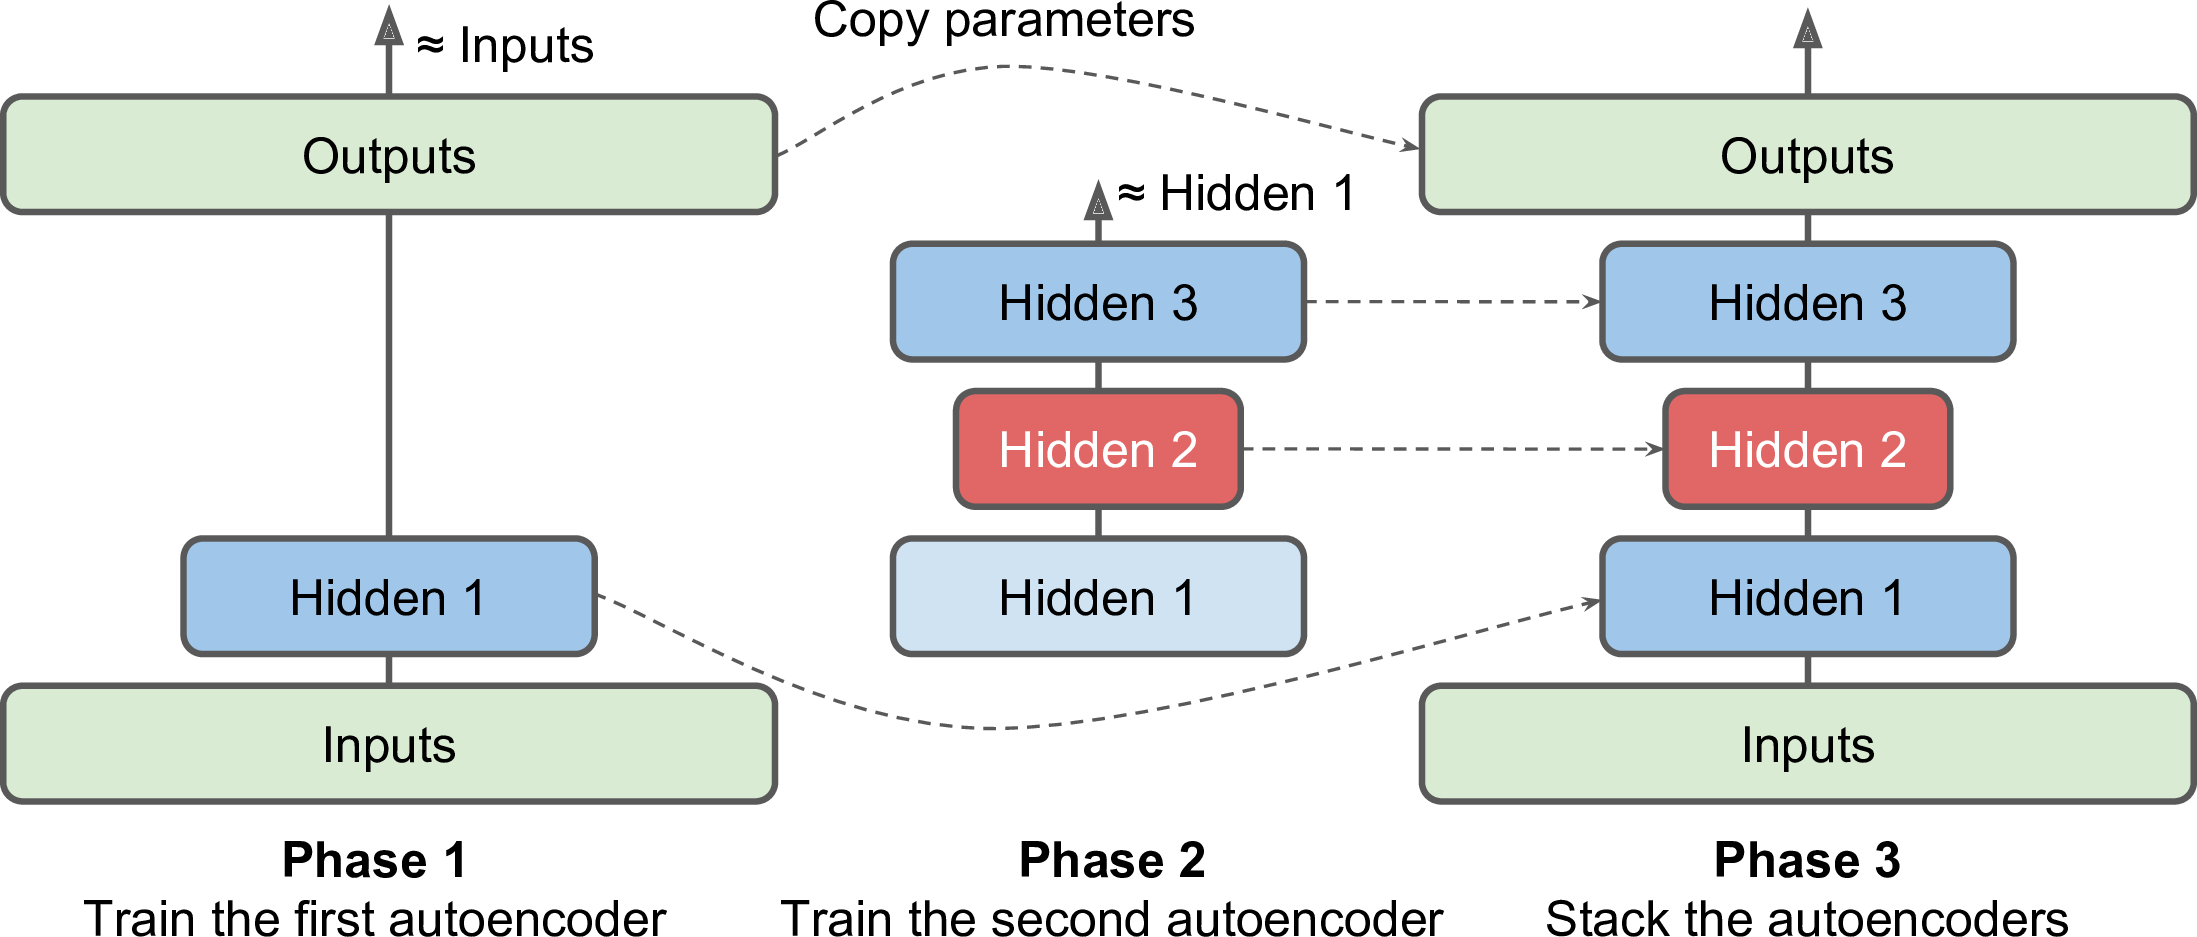

During the first phase of training, the first autoencoder learns to reconstruct the inputs. During the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder’s hidden layer. Finally, you just build a big sandwich using all these autoencoders.<br/>

To implement this multiphase training algorithm, the simplest approach is to use a different TensorFlow graph for each phase. After training an autoencoder, you just run the training set through it and capture the output of the hidden layer. This output then serves as the training set for the next autoencoder. Once all autoencoders have been trained this way, you simply copy the weights and biases from each autoencoder and use them to build the stacked autoencoder.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [28]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [29]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, 
                                                  n_neurons=300, n_epochs=4, 
                                                  batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, 
                                      n_epochs=4, batch_size=150)

09% Train MSE: 0.0186772
1 Train MSE: 0.0195928
29% Train MSE: 0.0185367
39% Train MSE: 0.0194414
0 Train MSE: 0.00433411
1 Train MSE: 0.00459767
29% Train MSE: 0.00436452
39% Train MSE: 0.00458709


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [30]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.nn.elu(tf.matmul(hidden3, W4) + b4)

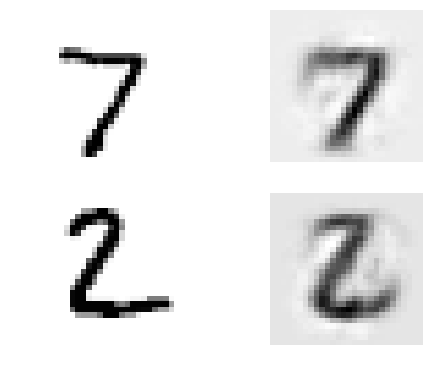

In [31]:
show_reconstructed_digits(X, outputs)

## Training one Autoencoder at a time in a <br/> single graph

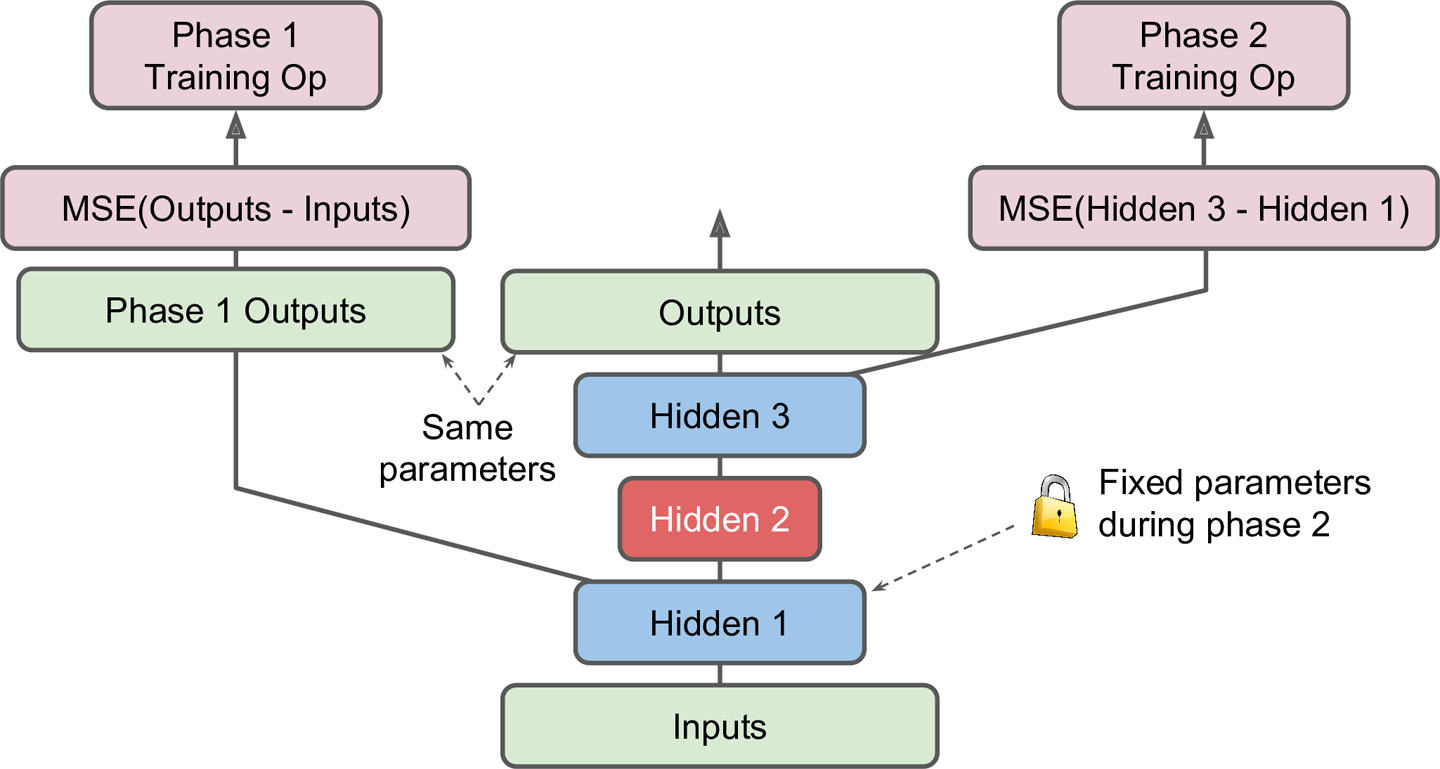

* The central column in the graph is the full stacked autoencoder. This part can be used after training.
* The left column is the set of operations needed to run the first phase of training. It creates an output layer that bypasses hidden layers 2 and 3. This output layer shares the same weights and biases as the stacked autoencoder’s output layer. On top of that are the training operations that will aim at making the output as close as possible to the inputs. Thus, this phase will train the weights and biases for the hidden layer 1 and the output layer (i.e., the first autoencoder).
* The right column in the graph is the set of operations needed to run the second phase of training. It adds the training operation that will aim at making the output of hidden layer 3 as close as possible to the output of hidden layer 1. Note that we must freeze hidden layer 1 while running phase 2. This phase will train the weights and biases for hidden layers 2 and 3 (i.e., the second autoencoder).

